In [1]:
# check the versions of key python libraries 

#import scipy
#print('scipy: %s' % scipy.__version__)

import numpy as np
print('numpy: %s' % np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)

import pandas as pd
print('pandas: %s' % pd.__version__)
from pandas.plotting import autocorrelation_plot

import statsmodels
print('statsmodels: %s' % statsmodels.__version__) # scikit-learn

import sklearn
print('sklearn: %s' % sklearn.__version__)

from sklearn.metrics import mean_squared_error

from tqdm import tqdm
#import requests
import zipfile

#import gc

!python --version



#pd.set_option('max_columns', 50)

numpy: 1.17.2
matplotlib: 3.1.1
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3
Python 3.7.4


In [2]:
# original data files
data_dir = './corona-virus-brazil/'

In [3]:
# download file
# source:
# https://www.kaggle.com/unanimad/corona-virus-brazil

print('downloading file .zip ...')
print()
!kaggle datasets download unanimad/corona-virus-brazil --force
print()
print('download finished!')
print()

with zipfile.ZipFile('corona-virus-brazil.zip', 'r') as zip_ref:
    zip_ref.extractall('corona-virus-brazil')
print('unziped!')

downloading file .zip ...

  0%|                                               | 0.00/19.1k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 19.1k/19.1k [00:00<00:00, 233kB/s]

download finished!

unziped!


In [4]:
!ls {data_dir}

brazil_covid19.csv     brazil_covid19_old.csv


In [5]:
covid_br = pd.read_csv(data_dir + 'brazil_covid19.csv')
print('Covid BR has {} rows and {} columns'.format(covid_br.shape[0], covid_br.shape[1]))
print()
print('Last information in ' + covid_br.iloc[-1,0])


Covid BR has 2700 rows and 5 columns

Last information in 2020-05-08


In [6]:
covid_br.head()

,date,region,state,cases,deaths
0,2020-01-30,Centro-Oeste,Distrito Federal,0,0
1,2020-01-30,Centro-Oeste,Goiás,0,0
2,2020-01-30,Centro-Oeste,Mato Grosso,0,0
3,2020-01-30,Centro-Oeste,Mato Grosso do Sul,0,0
4,2020-01-30,Nordeste,Alagoas,0,0


In [7]:
covid_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
date      2700 non-null object
region    2700 non-null object
state     2700 non-null object
cases     2700 non-null int64
deaths    2700 non-null int64
dtypes: int64(2), object(3)
memory usage: 105.6+ KB


In [8]:
df = covid_br[covid_br["state"] == "Amazonas"]

df = df[df["deaths"] > 0]

df.tail(5)

,date,region,state,cases,deaths
2580,2020-05-04,Norte,Amazonas,7242,584
2607,2020-05-05,Norte,Amazonas,8109,649
2634,2020-05-06,Norte,Amazonas,9243,751
2661,2020-05-07,Norte,Amazonas,10099,806
2688,2020-05-08,Norte,Amazonas,10727,874


In [9]:
df.shape

(45, 5)

In [10]:
df.describe()

,cases,deaths
count,45.000000,45.000000
mean,2727.844444,211.866667
std,2914.493890,242.619099
min,54.000000,1.000000
25%,417.000000,14.000000
50%,1719.000000,124.000000
75%,3928.000000,320.000000
max,10727.000000,874.000000


### Feature Engineering

In [11]:
# datetime

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-03-25 to 2020-05-08
Data columns (total 4 columns):
region    45 non-null object
state     45 non-null object
cases     45 non-null int64
deaths    45 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


In [12]:
# creating month and day

df['month'] = [df.index[i].month for i in range(len(df))]
df['day'] = [df.index[i].day for i in range(len(df))] 

df.head()

,region,state,cases,deaths,month,day
date,,,,,,
2020-03-25,Norte,Amazonas,54,1,3,25
2020-03-26,Norte,Amazonas,67,1,3,26
2020-03-27,Norte,Amazonas,81,1,3,27
2020-03-28,Norte,Amazonas,111,1,3,28
2020-03-29,Norte,Amazonas,140,1,3,29


## Test Harness

### Validation Dataset

In [13]:
deaths = pd.Series(df['deaths'])
split_size = round(len(deaths) * 0.90)
dataset, validation = deaths[0:split_size], deaths[split_size:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 40, Validation 5


/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [14]:
# https://medium.com/@bingobee01/pandas-tricks-and-tips-a7b87c3748ea

## Persistence - Base Line Model

In [15]:
# load data

X = dataset.values
X = X.astype('float32')
split_size = 0.70

train_size = round(len(X) * split_size)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=193.000, Expected=207
>Predicted=207.000, Expected=234
>Predicted=234.000, Expected=255
>Predicted=255.000, Expected=287
>Predicted=287.000, Expected=304
>Predicted=304.000, Expected=320
>Predicted=320.000, Expected=351
>Predicted=351.000, Expected=380
>Predicted=380.000, Expected=425
>Predicted=425.000, Expected=476
>Predicted=476.000, Expected=501
>Predicted=501.000, Expected=548
RMSE: 31.881


## Data Analysis

### Summary Statistics

In [16]:
deaths.describe()

count     45.000000
mean     211.866667
std      242.619099
min        1.000000
25%       14.000000
50%      124.000000
75%      320.000000
max      874.000000
Name: deaths, dtype: float64

### Line Plot

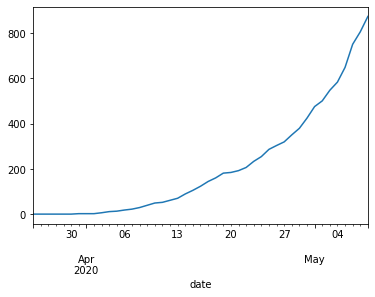

In [17]:
deaths.plot()
plt.show()

- Increasing trend of cases over time.
- There do not appears to be systematic seasonality to the cases for each day.
- There do not appear to be any obvious outliers.

### Autocorrelation

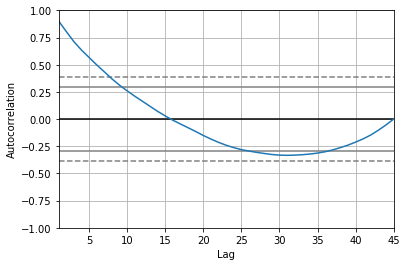

In [18]:
# autocorrelation
autocorrelation_plot(deaths)
plt.show()

- there are high correlations before day 6.

### Histogram and Density Plot

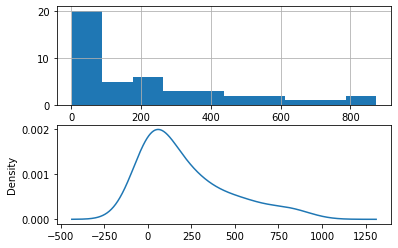

In [19]:
plt.figure(1)
plt.subplot(211)
deaths.hist()

plt.subplot(212)
deaths.plot(kind='kde')
plt.show()

- The distribution is not Guassian.
- The shape has a long right rail and may suggest an exponential distribution.

### Box and Whisker Plots

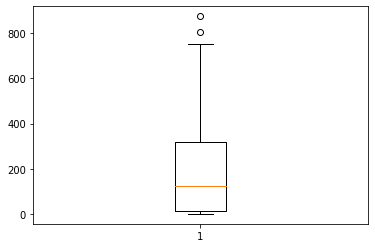

In [20]:
plt.boxplot(deaths)
plt.show()

- There are outliers on the top.

## ARIMA Models

In [21]:
from statsmodels.tsa.arima_model import ARIMA

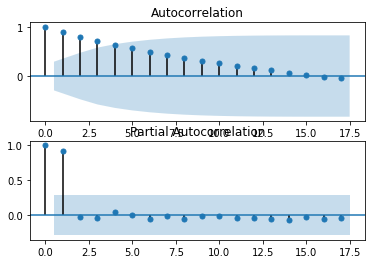

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(deaths, ax=plt.gca())
plt.subplot(212)
plot_pacf(deaths, ax=plt.gca())
plt.show()

In [23]:
# ARIMA
p = 0   # Autocorrelation Function (ACF)

d = 1   # level of differencing

q = 2   # Partial Autocorrelation Function (PACF)

/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.deaths   No. Observations:                   44
Model:                 ARIMA(0, 1, 2)   Log Likelihood                   7.672
Method:                       css-mle   S.D. of innovations              0.203
Date:                Sat, 09 May 2020   AIC                             -7.344
Time:                        19:26:36   BIC                             -0.207
Sample:                    03-26-2020   HQIC                            -4.697
                         - 05-08-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1545      0.031      4.912      0.000       0.093       0.216
ma.L1.D.deaths     0.1826      0.152      1.202      0.236      -0.115       0.480
ma.L2.D.deaths    -0.1588      0.126

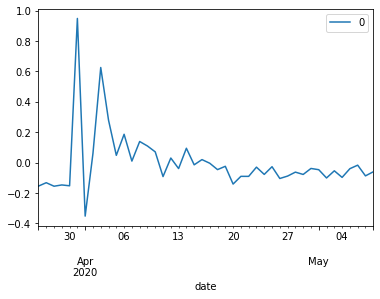

               0
count  44.000000
mean   -0.000415
std     0.205495
min    -0.351891
25%    -0.090748
50%    -0.042867
75%     0.022563
max     0.948610


In [24]:
# fit model
model = ARIMA(np.log(deaths), order=(p,d,q))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

### Grid Search ARIMA Hyperparameters

In [25]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order): # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
             for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)

warnings.filterwarnings("ignore")

evaluate_models(deaths.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [ ]:
deaths

### Moving Average as Data Preparation

In [ ]:
deaths = pd.Series(df['deaths'])
rolling = deaths.rolling(window=3) 
rolling_mean = rolling.mean() 
print(rolling_mean.head(10))

In [ ]:
# plot original and transformed dataset 
deaths.plot() 
rolling_mean.plot(color='red') 
plt.show()

### Moving Average as Feature Engineering

In [ ]:


# prepare situation
X = deaths.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)]) 
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

# zoom plot
#pyplot.plot(test[:100]) pyplot.plot(predictions[:100], color='red') pyplot.show()

### Is your Time Series White Noise?

In [ ]:
deaths.describe()

# mean is not zero
# standard deviation is high

In [ ]:
# histogram plot
deaths.hist()
plt.show()

# histogram is not a bell curve.

### Check Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# statistical test

# The null hypothesis of the test is that the time series is non-stationary.
# https://machinelearningmastery.com/time-series-data-stationary-python/
# https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test

result = adfuller(deaths) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Time Series Components

Systematic Components:
- Level
- Trend
- Seasonality

Nos-Systematic Component:
- Noise


### Automatic Time Series Decomposition

### Additive Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(deaths, model='additive', freq=1) 
result.plot()
plt.show()

### Multiplicative Decomposition

In [ ]:
result = seasonal_decompose(deaths, model='multiplicative', freq=1) 
result.plot()
plt.show()

### Log transformation

In [ ]:
result = adfuller(np.log(deaths)) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Detrend by Model Fitting

In [ ]:
from sklearn.linear_model import LinearRegression

# fit linear model
X = [i for i in range(0, len(deaths))]
X = np.reshape(X, (len(X), 1))
y = deaths.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(deaths))]

# plot detrended
plt.plot(detrended)
plt.show()

In [ ]:
detrended

In [ ]:
result = adfuller(detrended) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))